# Milestone 3 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Taira Miyatake<br>

## Deliverables

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc.
- Discussion of the performances you achieved, and how you might be able to improve them in the future

## Import Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
import warnings

## Overview

In this milestone, we will use movie metadata extracted from TMDb and IMDb to train two "traditional" ML classifiers to predict movie genres. We will not use movie poster data for now. 

### Performance Metrics

Evaluation of model performance is tricky, due to the multi-label nature of the problem. For example, if a movie's true genre labels are A and B, but our model only predicted label A (or B, but not both) -- was this prediction correct or wrong? And what if the model predicted labels A and B plus an extra C genre? In order to calculate "test accuracy", we would have to define it and decide whether we valued precision or recall more?

Earlier, we decided to have 20 outcome variables. For each movie, we have 19 binary (1/0) flags, one for each of the 19 genre classifications used by TMDb (namely Adventure, Fantasy, Animation, Drama, Horror, Action, Comedy, History, Western, Thriller, Crime, Documentary, Science Fiction, Mystery, Music, Romance, Family, War and Foreign), and a 20th outcome variable, the number of genres assigned (see Milestone 2 on our choice of outcome variables).

After extensive discussion, we felt that in line with our choice of outcome variables, we could evaluate our model's performance on each outcome variable separately. We will have 19 test accuracies (one for each genre), which can be visualized and summarized by taking the mean.

### Data Preparation

The data was manipulated and cleaned in Milestone 2 in preparation for modelling. In summary, our final dataframe consisted of the following variables:

*Predictors from TMDb*
- Title and plot summary, which have been converted using bag-of-words analysis into a term frequency times inverse document frequency (tf-idf) matrix of 389 vocabulary words (that make up at least 1% of the corpus) 
- Production company, which has been converted into 20 indicator variables, representing the top 20 production companies with the most films
- Release date, which has been transformed into release year and release month
- Runtime (mins)
- Budget (USD)
- Revenue (USD)
- Popularity
- Average user rating (on scale of 1-10)

*Predictors from IMDb*
- Cast (first 5 listed), directors (first 2 listed) and writers (first 2 listed), which have been converted into 150, 75 and 75 indicator variables respectively, representing the top 150 cast and top 75 directors and writers with the most films
- US MPAA picture rating (eg. PG-13, R-21 etc.)

*Outcome Variables*
- TMDb genres, which have been dummy-coded into 19 indicator variables, one for each genre category
- Number of TMDb genre tags

---

## Prepare Train & Test Sets

In [8]:
# read in dataframe
data = pd.read_csv("/home/ubuntu/data/clean_data/milestone3/merged3.csv")
data = data.drop(['Unnamed: 0', 'tmdb_id', 'imdb_id'], axis=1)
data.head()

/home/ubuntu/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,budget,revenue,runtime,popularity,user_rating,release_year,release_month,USA_rating,Warner Bros,Metro-Goldwyn-Mayer MGM,...,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,0.0,0.0,69,0.623849,6.8,1988.0,10.0,Missing,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,76,0.288572,6.8,1986.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,4000000.0,4300000.0,98,1.76899,6.4,1995.0,12.0,R,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,12136938.0,110,0.676269,6.6,1993.0,10.0,R,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,42000.0,0.0,80,0.125477,5.2,2006.0,1.0,Missing,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# convert data types
data['runtime'] = data['runtime'].apply(pd.to_numeric, errors='coerce')
data['popularity'] = data['popularity'].apply(pd.to_numeric, errors='coerce')

# replace nan
data['runtime'].fillna(0, inplace=True)
data['popularity'].fillna(0, inplace=True)

In [10]:
data.shape

(69915, 734)

In [11]:
# separate x and y
y = data.ix[:, 714:734]
x = data.ix[:, 0:714]

In [12]:
y.head()

,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
y.shape

(69915, 20)

In [14]:
x.head()

,budget,revenue,runtime,popularity,user_rating,release_year,release_month,USA_rating,Warner Bros,Metro-Goldwyn-Mayer MGM,...,word_work,word_working,word_works,word_world,word_writer,word_written,word_year,word_years,word_york,word_young
0,0.0,0.0,69.0,0.623849,6.8,1988.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,76.0,0.288572,6.8,1986.0,10.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,4000000.0,4300000.0,98.0,1.768986,6.4,1995.0,12.0,R,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,12136938.0,110.0,0.676269,6.6,1993.0,10.0,R,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,42000.0,0.0,80.0,0.125477,5.2,2006.0,1.0,Missing,0.0,0.0,...,0.0,0.0,0.0,0.119018,0.0,0.180166,0.0,0.0,0.165786,0.0


In [15]:
x.shape

(69915, 714)

In [16]:
# get dummy variables for release_year, release_month, USA_rating
x = pd.get_dummies(x, columns=['release_year', 'release_month', 'USA_rating'])

In [17]:
# scale the data
x = preprocessing.scale(x)

In [18]:
# create training and testing sets (66% train, 33% test)
np.random.seed(123)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [19]:
x_train.shape

(46843, 878)

In [20]:
x_test.shape

(23072, 878)

In [21]:
# select 19 genre classes
y_train19 = y_train.ix[:, 0:19]
y_test19 = y_test.ix[:, 0:19]

---

## Model 0: Baseline Model

Here, we create a baseline model, which flags a genre '1' randomly at a probability of around 10%, which is the overall proportion of flag '1' across all 19 genre classes. This serves as a benchmark for our two subsequent models. 

In [22]:
def random_classifier(df_y):
    prop = df_y.sum() / df_y.shape[0]
    pred = np.random.binomial(1, np.mean(prop), df_y.shape)
    return pred

In [23]:
# naive model
np.random.seed(123)
pred_baseline = random_classifier(y_test19)

# show test accuracies for each class
acc_baseline = np.mean(pred_baseline == y_test19)
acc_baseline

Adventure          0.844227
Fantasy            0.860220
Animation          0.850251
Drama              0.564277
Horror             0.808296
Action             0.777306
Comedy             0.662925
History            0.875390
Western            0.877080
Thriller           0.777739
Crime              0.827063
Documentary        0.827497
Science Fiction    0.849341
Mystery            0.859180
Music              0.861867
Romance            0.789485
Family             0.843750
War                0.875347
Foreign            0.840803
dtype: float64

In [24]:
# overall accuracy
print ("Overall baseline accuracy", round(acc_baseline.sum() / 19 * 100, 2))

Overall baseline accuracy 81.43


In [25]:
# F1 score
print ("Precision baseline", round(metrics.precision_score(y_test19, pred_baseline, average='weighted'), 3))
print ("Recall baseline", round(metrics.recall_score(y_test19, pred_baseline, average='weighted'), 3))
print ("F1 score baseline", round(metrics.f1_score(y_test19, pred_baseline, average='weighted'), 3))

Precision baseline 0.196
Recall baseline 0.105
F1 score baseline 0.121


---

## Model 1: Random Forest

Given this multi-class, multi-label problem, we will employ one-vs-rest (OvR) strategy, which consists of fitting one classifier per genre. For each classifier, the genre is fitted against all the other genres. 

To address the imbalanced nature of this dataset (as discussed in Milestone 2), we will use balanced class weights.

### [UPDATE] Parameter Tuning

In [33]:
warnings.filterwarnings('ignore')

rf = RandomForestClassifier(class_weight="balanced",oob_score=True)
# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 85
oob_error_list=[]
for i in range(min_estimators, max_estimators,5):
    print(i)
    rf.set_params(n_estimators=i)
    rf.fit(x_train, y_train19)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    oob_error_list.append(oob_error)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80


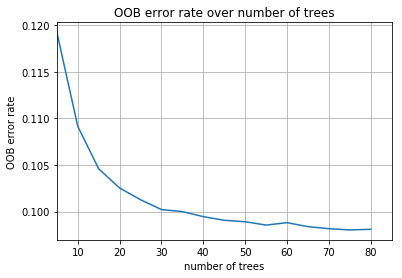

In [68]:
n_tree=range(min_estimators, max_estimators,5)
plt.title('OOB error rate over number of trees')
plt.plot(n_tree, oob_error_list)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("number of trees")
plt.ylabel("OOB error rate")
plt.grid()
plt.show()

In [26]:
# fit random forest
rf = RandomForestClassifier(n_estimators=80,class_weight="balanced",oob_score=True)
rf.fit(x_train, y_train19)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [33]:
# predict on test set
pred_rf = rf.predict(x_test)

# show test accuracies for each class
acc_rf = np.mean(pred_rf == y_test19)
acc_rf

Adventure          0.931432
Fantasy            0.954534
Animation          0.948422
Drama              0.681085
Horror             0.893984
Action             0.849948
Comedy             0.715066
History            0.973994
Western            0.975035
Thriller           0.852809
Crime              0.912448
Documentary        0.920856
Science Fiction    0.937977
Mystery            0.953753
Music              0.955921
Romance            0.864424
Family             0.931215
War                0.974645
Foreign            0.929828
dtype: float64

In [37]:
# overall accuracy
print ("Overall random forest accuracy", round(acc_rf.sum() / 19 * 100, 2), "%\n")

Overall random forest accuracy 90.3 %



In [38]:
# F1 score
print ("Precision random forest", round(metrics.precision_score(y_test19, pred_rf, average='weighted'), 3))
print ("Recall random forest", round(metrics.recall_score(y_test19, pred_rf, average='weighted'), 3))
print ("F1 score random forest", round(metrics.f1_score(y_test19, pred_rf, average='weighted'), 3))

Precision random forest 0.814
Recall random forest 0.122
F1 score random forest 0.16


In [24]:
# save random forest to disk
path = 'models/rf.sav'
pickle.dump(rf, open(path, 'wb'))

---

## Model 2: *k*-Nearest Neighbors

### [UPDATE] Parameter Tuning

In [ ]:
k_list=range(5,15)
k_fold = KFold(n_splits=2)
acc_list=[]
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores=[]
    for train, test in k_fold.split(x_train):
        knn.fit(x_train[train], np.array(y_train19)[train])
        score=knn.score(x_train[test], np.array(y_train19)[test])
        scores.append(score)
    acc_list.append(np.mean(scores))

In [27]:
# fit knn where k=5
knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train19)

In [28]:
# predict on test set
pred_knn = knn.predict(x_test)

# show test accuracies for each class
acc_knn = np.mean(pred_knn == y_test19)
acc_knn

Adventure          0.931215
Fantasy            0.954230
Animation          0.953537
Drama              0.573812
Horror             0.893074
Action             0.850555
Comedy             0.634752
History            0.973128
Western            0.976162
Thriller           0.846481
Crime              0.905340
Documentary        0.911841
Science Fiction    0.937283
Mystery            0.954187
Music              0.961122
Romance            0.855626
Family             0.932386
War                0.974515
Foreign            0.926881
dtype: float64

In [18]:
# overall accuracy
print "Overall k-nearest neighbors accuracy", round(acc_knn.sum() / 19 * 100, 2), "%\n"

Overall k-nearest neighbors accuracy 89.06 %



In [20]:
# F1 score
print "Precision k-nearest neighbors", round(metrics.precision_score(y_test19, pred_knn, average='weighted'), 3)
print "Recall k-nearest neighbors", round(metrics.recall_score(y_test19, pred_knn, average='weighted'), 3)
print "F1 score k-nearest neighbors", round(metrics.f1_score(y_test19, pred_knn, average='weighted'), 3)

Precision k-nearest neighbors 0.374
Recall k-nearest neighbors 0.184
F1 score k-nearest neighbors 0.224


In [33]:
# save knn to disk
path = 'models/knn.sav'
pickle.dump(knn, open(path, 'wb'))

---

SVM was considered as an alternative model but was not used in view of computation time.

Since sklearn's support vector classifier does not have inherent multi-label support, we wrap it with the OneVsRestClassifer function. In view of computation time, we used a linear kernel here (rather than RBF).

In [ ]:
# fit linear svm
svm = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced')).fit(x_train, y_train19)

---

## Logistic Regression Model for Number of Genre Labels

In addition to the 19 genre outcomes, we want another model that can predict the number of genres to be assigned to each movie. Using this predicted number, we can then assign genres to each test movie when we also have the predicted probabilities of every genre (obtained from above models). Here, we use logistic regression to predict the number of genre labels, by treating it as a categorical variable (with multiple classes).

In [47]:
# select number of genre labels as outcome
y_train20 = y_train.ix[:, 19]
y_test20 = y_test.ix[:, 19]

In [ ]:
# fit logistic regression
log = LogisticRegression(class_weight='balanced').fit(x_train, y_train20)

In [36]:
# predict on test set
pred_log = log.predict(x_test)

# calculate accuracy
acc_log = np.mean(pred_log == y_test20)

print "Overall model accuracy:", round(acc_log * 100, 2), "%\n"
print "Confusion matrix:"
pd.crosstab(pred_log, y_test20, rownames=['True'], colnames=['Predicted'], margins=True)

Overall accuracy: 32.35 %

Confusion matrix:


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
True,,,,,,,,,,
2.0,38,9719,7378,3782,1124,240,42,4,1,22328
3.0,0,31,47,58,31,8,1,0,0,176
4.0,0,13,19,23,14,3,5,0,0,77
5.0,0,20,18,22,12,8,0,0,0,80
6.0,0,32,51,95,69,28,6,0,0,281
7.0,0,12,29,43,17,12,2,0,0,115
10.0,0,8,4,2,1,0,0,0,0,15
All,38,9835,7546,4025,1268,299,56,4,1,23072


We note that the accuracy of this model which predicts the number of genre labels is fairly low (32%). This is partly due to a large number of classes.

However, we know from earlier data exploration that the majority of movies are tagged with 3 or less genres (see Milestone 2). If we believe that it is more important to have few but highly accurate genre tags, as opposed to more but less accurate tags, then in the final combined prediction, we should simply assign each movie 1 or 2 genres with the highest predicted probabilities (eg. from the random forest), rather than using this predicted number of genre labels.

In [37]:
# save log to disk
path = 'models/log.sav'
pickle.dump(log, open(path, 'wb'))

---

## Model Comparison

Here, we visualize the performance of our two models across all 19 genres.

In [38]:
# convert accuracies to dataframe 
acc1 = pd.DataFrame(acc_baseline, columns=['Baseline'])
acc2 = pd.DataFrame(acc_knn, columns=['KNN'])
acc3 = pd.DataFrame(acc_rf, columns=['Random Forest'])

# merge into one dataframe
acc = pd.concat([acc1, acc2, acc3], axis=1)

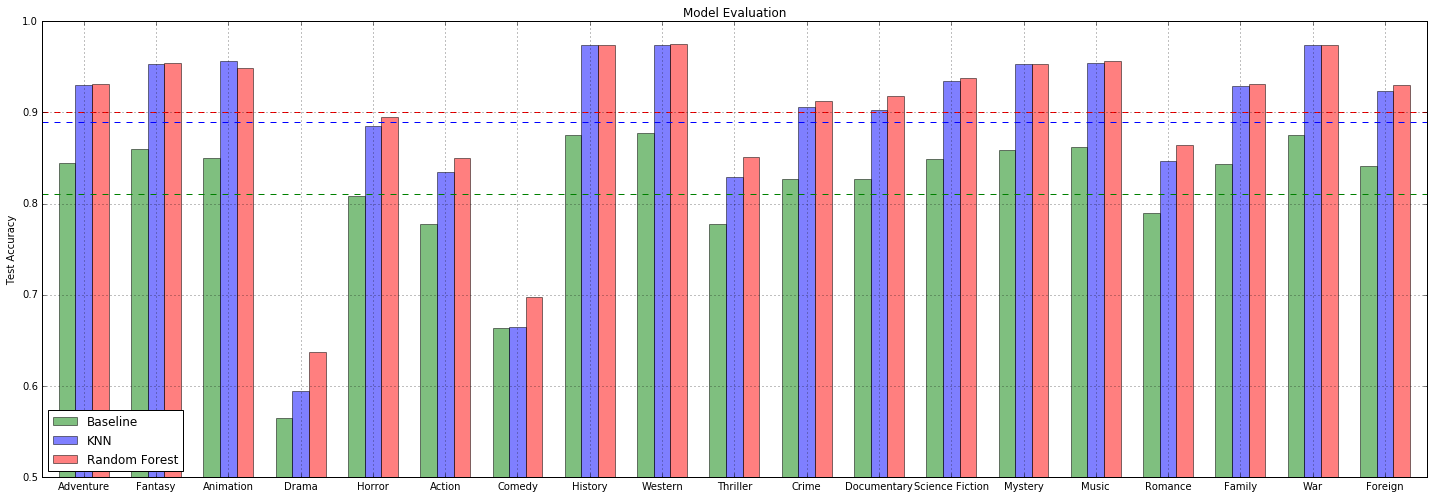

In [41]:
# create plot
fig, ax = plt.subplots(figsize=(20,7))
pos = list(range(len(acc['Baseline'])))
width = 0.23

# baseline bars
plt.bar(pos, acc['Baseline'], width, alpha=0.5, color='green', label='Baseline')

# knn bars
plt.bar([p + width for p in pos], acc['KNN'], width, alpha=0.5, color='b', label='KNN')

# random forest bars
plt.bar([p + width*2 for p in pos], acc['Random Forest'], width, alpha=0.5, color='r', label='Random Forest')

# labels
ax.set_xlabel('Genre')
ax.set_ylabel('Test Accuracy')
ax.set_title('Model Evaluation')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(acc.index)

# limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim(0.5, 1.0)

# overall accuracies
plt.axhline(y=0.90, color='r', linestyle='dashed')
plt.axhline(y=0.89, color='b', linestyle='dashed')
plt.axhline(y=0.81, color='g', linestyle='dashed')

plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

In [39]:
# save to csv
acc.to_csv('model_acc.csv')

In [36]:
labels=y_test19.columns.tolist()
print('genre\t','baseline\t','random forest\t','knn\t')
prec_baselines,prec_rfs,prec_knns=[],[],[]
for i in range(len(labels)):
    prec_base= round(metrics.precision_score(y_test19.iloc[:,i], pred_baseline[:,i], average='binary'),3)
    prec_rf=round(metrics.precision_score(y_test19.iloc[:,i], pred_rf[:,i], average='binary'),3)
    prec_knn=round(metrics.precision_score(y_test19.iloc[:,i], pred_knn[:,i], average='binary'),3)
    print(labels[i],prec_base,prec_rf,prec_knn)
    prec_baselines.append(prec_base)
    prec_rfs.append(prec_rf)
    prec_knns.append(prec_knn)
   

genre	 baseline	 random forest	 knn	
Adventure 0.075 0.571 0.484
Fantasy 0.044 1.0 0.484
Animation 0.056 0.992 0.905
Drama 0.416 0.674 0.486
Horror 0.1 0.952 0.497
Action 0.16 0.969 0.559
Comedy 0.315 0.669 0.377
History 0.024 1.0 0.091
Western 0.025 1.0 0.714
Thriller 0.146 0.727 0.353
Crime 0.084 0.75 0.22
Documentary 0.092 0.944 0.498
Science Fiction 0.061 1.0 0.386
Mystery 0.044 1.0 0.643
Music 0.036 1.0 0.77
Romance 0.136 0.895 0.309
Family 0.072 0.921 0.658
War 0.026 1.0 0.458
Foreign 0.067 1.0 0.21


In [40]:
# convert precuracies to dataframe 
prec1 = pd.DataFrame(prec_baselines, columns=['Baseline'])
prec2 = pd.DataFrame(prec_knns, columns=['KNN'])
prec3 = pd.DataFrame(prec_rfs, columns=['Random Forest'])

# merge into one dataframe
prec = pd.concat([prec1, prec2, prec3], axis=1)
prec.index=labels

In [41]:
prec

,Baseline,KNN,Random Forest
Adventure,0.075,0.484,0.571
Fantasy,0.044,0.484,1.000
Animation,0.056,0.905,0.992
Drama,0.416,0.486,0.674
Horror,0.100,0.497,0.952
Action,0.160,0.559,0.969
Comedy,0.315,0.377,0.669
History,0.024,0.091,1.000
Western,0.025,0.714,1.000
Thriller,0.146,0.353,0.727


### [UPDATE] New Plots of Precision/Recall by Genre

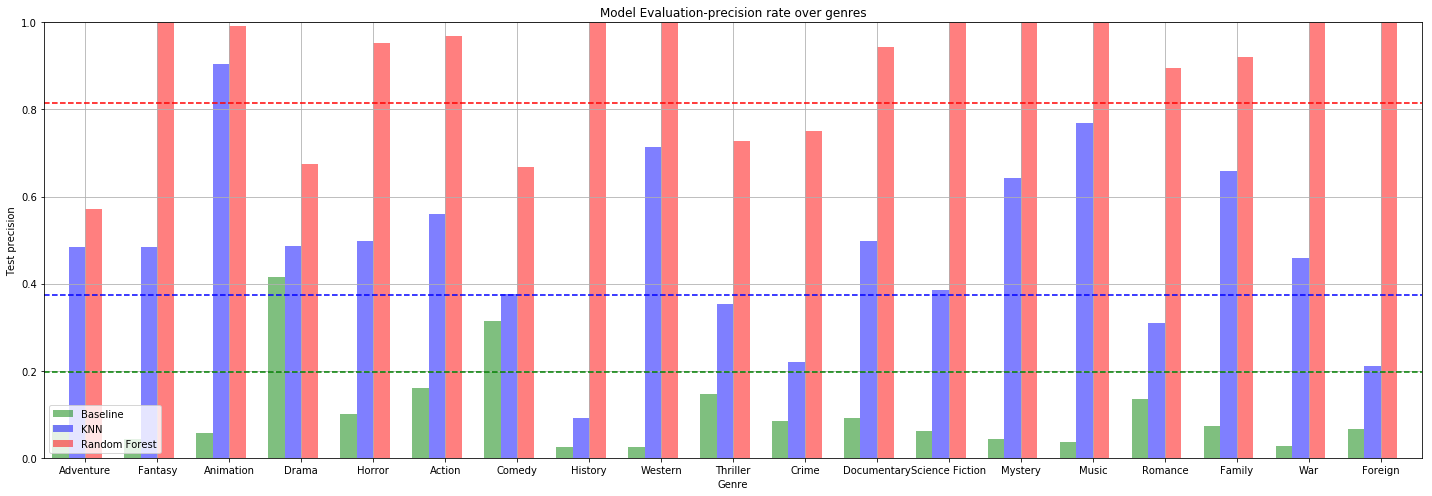

In [54]:
# create plot
fig, ax = plt.subplots(figsize=(20,7))
pos = list(range(len(prec['Baseline'])))
width = 0.23

# baseline bars
plt.bar(pos, prec['Baseline'], width, alpha=0.5, color='green', label='Baseline')

# knn bars
plt.bar([p + width for p in pos], prec['KNN'], width, alpha=0.5, color='b', label='KNN')

# random forest bars
plt.bar([p + width*2 for p in pos], prec['Random Forest'], width, alpha=0.5, color='r', label='Random Forest')

# labels
ax.set_xlabel('Genre')
ax.set_ylabel('Test precision')
ax.set_title('Model Evaluation-precision rate over genres')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(prec.index)

# limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim(0.0, 1.0)

# overall precision
plt.axhline(y=0.814, color='r', linestyle='dashed')
plt.axhline(y=0.374, color='b', linestyle='dashed')
plt.axhline(y=0.196, color='g', linestyle='dashed')

plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.savefig('/data/precision.png')
plt.show()

In [45]:
#labels=y_test19.columns.tolist()
print('genre\t','baseline\t','random forest\t','knn\t')
rec_baselines,rec_rfs,rec_knns=[],[],[]
for i in range(len(labels)):
    rec_base= round(metrics.recall_score(y_test19.iloc[:,i], pred_baseline[:,i], average='binary'),3)
    rec_rf=round(metrics.recall_score(y_test19.iloc[:,i], pred_rf[:,i], average='binary'),3)
    rec_knn=round(metrics.recall_score(y_test19.iloc[:,i], pred_knn[:,i], average='binary'),3)
    print(labels[i],rec_base,rec_rf,rec_knn)
    rec_baselines.append(rec_base)
    rec_rfs.append(rec_rf)
    rec_knns.append(rec_knn)

genre	 baseline	 random forest	 knn	
Adventure 0.111 0.005 0.029
Fantasy 0.099 0.005 0.028
Animation 0.103 0.093 0.204
Drama 0.106 0.459 0.341
Horror 0.099 0.008 0.073
Action 0.111 0.009 0.06
Comedy 0.113 0.083 0.348
History 0.096 0.003 0.003
Western 0.103 0.007 0.086
Thriller 0.104 0.009 0.044
Crime 0.098 0.004 0.031
Documentary 0.108 0.107 0.152
Science Fiction 0.098 0.002 0.015
Mystery 0.097 0.002 0.025
Music 0.082 0.007 0.177
Romance 0.102 0.005 0.048
Family 0.103 0.022 0.076
War 0.109 0.002 0.019
Foreign 0.096 0.006 0.013


In [47]:
# convert recuracies to dataframe 
rec1 = pd.DataFrame(rec_baselines, columns=['Baseline'])
rec2 = pd.DataFrame(rec_knns, columns=['KNN'])
rec3 = pd.DataFrame(rec_rfs, columns=['Random Forest'])

# merge into one dataframe
rec = pd.concat([rec1, rec2, rec3], axis=1)
rec.index=labels

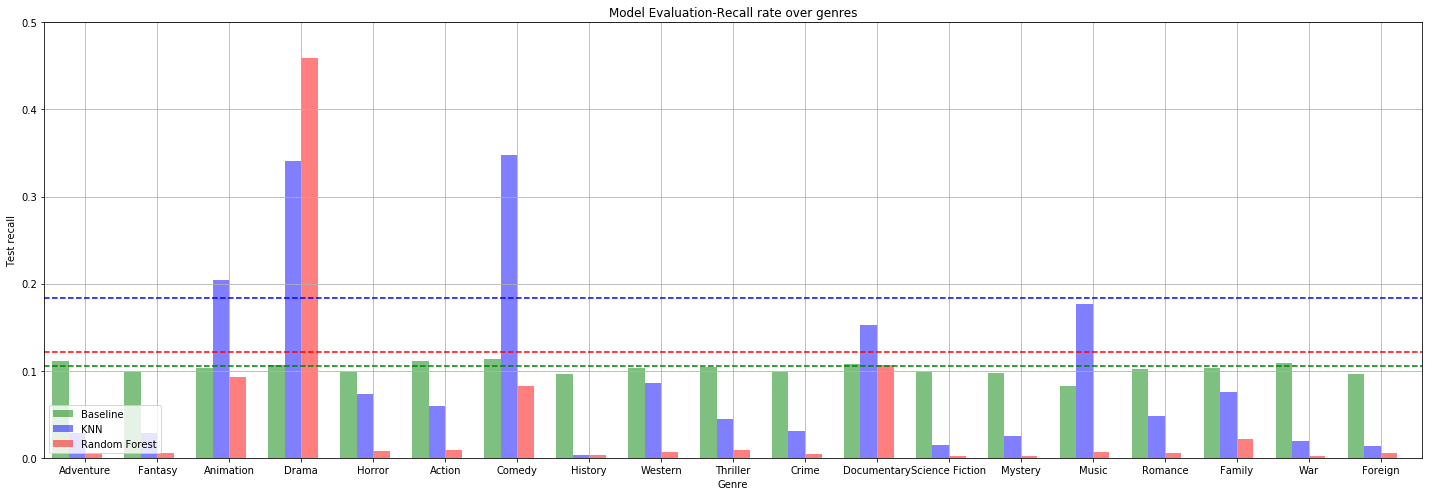

In [55]:
# create plot
fig, ax = plt.subplots(figsize=(20,7))
pos = list(range(len(rec['Baseline'])))
width = 0.23

# baseline bars
plt.bar(pos, rec['Baseline'], width, alpha=0.5, color='green', label='Baseline')

# knn bars
plt.bar([p + width for p in pos], rec['KNN'], width, alpha=0.5, color='b', label='KNN')

# random forest bars
plt.bar([p + width*2 for p in pos], rec['Random Forest'], width, alpha=0.5, color='r', label='Random Forest')

# labels
ax.set_xlabel('Genre')
ax.set_ylabel('Test recall')
ax.set_title('Model Evaluation-Recall rate over genres')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(rec.index)

# limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim(0.0, 0.5)

# overall recall
plt.axhline(y=0.122, color='r', linestyle='dashed')
plt.axhline(y=0.184, color='b', linestyle='dashed')
plt.axhline(y=0.105, color='g', linestyle='dashed')

plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.savefig('/data/recall.png')
plt.show()

In general, both models achieved pretty similar test accuracy results across all genres, with the random forest model (overall accuracy 90%) slightly edging out the kNN model (overall accuracy 89%). Both models performed better than the baseline model (overall accuracy 81%), which was intentionally designed as a very high benchmark. The hardest genres to predict correctly were drama and comedy (test accuracies below 80%). Both models are able to deal well with non-linear decision boundaries. 

Since the majority of the genre labels are negative (coded '0'), we might want to focus on the positive flags. As opposed to test accuracy, the F1 score which is derived from precision and recall, does not give any credit for classifying true negatives. 

Ignoring the true negatives, we see a different model comparison. Although the kNN model has lower precision than the random forest, it has higher recall, leading to an overall higher F1 score. Recall reflects the model's ability to find all the positive flags, while precision reflects the model's ability to not flag as positive a genre that is negative. 

However, as mentioned in the earlier section, we may tend to prefer fewer but highly spot-on genre labels, as opposed to more but less accurate labels. As such, we might consider precision to be more important. If we weight precision more than recall, then the random forest may still turn out to be better.

---

## Discussion

We believe these are the strengths of our models:
- Large sample size (~70,000 observations in total, ~47,000 in training set and ~23,000 in testing set)
- Wide variety of promising predictors which were scraped from both IMDb and TMDb
- Use of methods that were appropriate for the multi-label problem
- Accounted for class imbalance

Our models had several weaknesses which we could have improved on as follows:
- The parameters of our models were not optimized. Given more time, we would conduct parameter tuning of our models to improve their performance.
- We note the large number of predictor (X) variables in our dataset (almost 880 including dummy variables). We could have applied PCA prior to modelling for dimensionality reduction. We could have also coded 'release year' into decades or five-year intervals instead of dummy-coding it directly to reduce the number of predictors somewhat.
- We could have incorporated poster data into our models. However, conversion of the w500 posters into pixel arrays resulted in a large matrix with 1,125,000 features (see Milestone 2). Given the large size of this matrix, it would not have been possible to load and manipulate it on our local machines.
- We could have explored other possible models such as SVM, LDA/QDA, boosting etc. and compared them.
- We could have considered other performance metrics such as sensitivity/specificity, AUC under ROC or precision-recall curve etc.

---

## Next Steps

Moving forward, we will employ deep learning for this task and train a network using movie poster images on AWS. We can compare its performance to the above traditional models trained on movie metadata and even combine both of them together.